In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from common.metrics import f1_m, recall_m, precision_m
from sklearn.preprocessing import LabelEncoder

In [8]:
data = pd.read_csv('normalized_mustard_dataset.csv')
data.head()

,file_name,utterance,context,sarcasm
0,1_60.wav,It's just a privilege to watch your mind at work.,['I never would have identified the fingerprin...,True
1,1_70.wav,I don't think I'll be able to stop thinking ab...,['This is one of my favorite places to kick ba...,True
2,1_80.wav,"Since it's not bee season, you can have my epi...","['Here we go. Pad thai, no peanuts.', 'But doe...",False
3,1_90.wav,"Lois Lane is falling, accelerating at an initi...",['A marathon? How many Superman movies are the...,False
4,1_105.wav,I'm just inferring this is a couch because the...,"[""Great Caesar's ghost, look at this place."", ...",True


In [9]:
embedding_size = 16
max_length = 60
padding_type = 'post'

In [115]:
data['sarcasm'].replace({True:1,False:0},inplace=True)
data.head()

,file_name,utterance,context,sarcasm
0,1_60.wav,It's just a privilege to watch your mind at work.,['I never would have identified the fingerprin...,1
1,1_70.wav,I don't think I'll be able to stop thinking ab...,['This is one of my favorite places to kick ba...,1
2,1_80.wav,"Since it's not bee season, you can have my epi...","['Here we go. Pad thai, no peanuts.', 'But doe...",0
3,1_90.wav,"Lois Lane is falling, accelerating at an initi...",['A marathon? How many Superman movies are the...,0
4,1_105.wav,I'm just inferring this is a couch because the...,"[""Great Caesar's ghost, look at this place."", ...",1


In [12]:
utterances = data['utterance'].values
sarcasm_states = data['sarcasm'].values

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(utterances)
train = tokenizer.texts_to_sequences(utterances)
padded_train_sequences = pad_sequences(train, maxlen=max_length, padding=padding_type)

label_encoder = LabelEncoder()
y_text_train = to_categorical(label_encoder.fit_transform(sarcasm_states))

vocab_size = len(tokenizer.word_index)

In [118]:
data.tail(5)

,file_name,utterance,context,sarcasm
685,2_169.wav,"Hes not right for the part, and if I suggest h...","['What am I gonna do now?', 'Just pass the tap...",1
686,2_235.wav,"Oh yeah he has a caretaker his older brother, ...","['Helo! Anybody in there order a celebrity?', ...",0
687,2_34.wav,Is it me or the greetings gone downhill around...,"['Hey', 'You son of a bitch!']",1
688,2_608.wav,"You are right, by saying nice, I am virtually ...","['Did I go to this school?', ""Hey, there's Mis...",1
689,2_524.wav,"Yes and we are ""very"" excited about it.","[""Anyway, if you don't feel like being alone t...",1


In [119]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(padded_train_sequences, y_text_train, test_size=0.2, random_state=42)

In [120]:
import codecs

In [121]:
def load_fasttext_vectors2(fname):
    embeddings_index = {}
    f = codecs.open(fname, encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        ft_word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[ft_word] = coefs
    f.close()
    return embeddings_index

In [23]:
w2v_model =  load_fasttext_vectors2("wiki-news-300d-1M.vec")

999995it [01:22, 12147.42it/s]


In [122]:
from tensorflow.keras.layers import Dense, Flatten, LSTM, Bidirectional, Conv1D, MaxPooling1D, Input, Embedding
from tensorflow.keras.models import Model

In [123]:
words_not_found = []
nb_words = len(tokenizer.word_index)
embedding_matrix = np.zeros((nb_words + 1, 300))
for word, i in tokenizer.word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = w2v_model.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

In [124]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size + 1, 300, weights=[embedding_matrix], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
lstm_layer = Bidirectional(LSTM(64,return_sequences=True))(max_1)

flatten = Flatten()(lstm_layer)
dense = Dense(75, activation='relu', name='fully_connected')(flatten)
out = Dense(2, activation='softmax')(dense)

model = Model(inputs=[input_data], outputs=[out])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 60)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 60, 300)           610800    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 57, 50)            60050     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 28, 50)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 28, 128)           58880     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3584)              0         
_________________________________________________________________
fully_connected (Dense)      (None, 75)                2688

In [125]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy', f1_m, precision_m, recall_m])

In [126]:
history = model.fit(X_text_train, y_text_train, batch_size=64, epochs=5, verbose=1)

Train on 552 samples
Epoch 1/5


2022-05-03 02:26:02.482000: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_49342_49526' and '__inference___backward_standard_lstm_50205_50692_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_50969' both implement 'lstm_c87532b8-8a82-4166-8a55-939d8f29c262' but their signatures do not match.


552/552 [==============================] - 6s 11ms/sample - loss: 0.7030 - accuracy: 0.5109 - f1_m: 0.5115 - precision_m: 0.5115 - recall_m: 0.5115
Epoch 2/5
552/552 [==============================] - 1s 2ms/sample - loss: 0.6888 - accuracy: 0.5417 - f1_m: 0.5389 - precision_m: 0.5389 - recall_m: 0.5389
Epoch 3/5
552/552 [==============================] - 1s 2ms/sample - loss: 0.6767 - accuracy: 0.5707 - f1_m: 0.5698 - precision_m: 0.5698 - recall_m: 0.5698
Epoch 4/5
552/552 [==============================] - 1s 2ms/sample - loss: 0.6453 - accuracy: 0.6250 - f1_m: 0.6240 - precision_m: 0.6240 - recall_m: 0.6240
Epoch 5/5
552/552 [==============================] - 1s 2ms/sample - loss: 0.5073 - accuracy: 0.7681 - f1_m: 0.7694 - precision_m: 0.7694 - recall_m: 0.7694


## Testing Text Model

In [127]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_text_test, y_text_test, verbose=0)
print(f"loss: {loss}\naccuracy:{accuracy}\nf1_score:{f1_score}\nprecision:{precision}\nrecall:{recall}")

2022-05-03 02:26:13.188909: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_51548' and '__inference_standard_lstm_51548_specialized_for_model_2_bidirectional_2_forward_lstm_2_StatefulPartitionedCall_at___inference_distributed_function_52524' both implement 'lstm_1e88a22b-f97a-4950-a32f-7594141cb787' but their signatures do not match.


loss: 0.7793718602346338
accuracy:0.6521739363670349
f1_score:0.6862499117851257
precision:0.6862500309944153
recall:0.6862500309944153


In [128]:
user_statement = input("Tell me something sarcastic: \n")
tokenized_statement = tokenizer.texts_to_sequences([user_statement])
tokenized_statement = pad_sequences(tokenized_statement, maxlen=max_length, padding=padding_type)
output = model.predict(tokenized_statement)[0]

if np.argmax(output) == 0:
    print("Non-sarcastic")
elif np.argmax(output) == 1:
    print("Sarcasm")
print(output)

2022-05-03 02:26:17.741308: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_52818_specialized_for_model_2_bidirectional_2_forward_lstm_2_StatefulPartitionedCall_at___inference_distributed_function_53609' and '__inference_cudnn_lstm_with_fallback_52929' both implement 'lstm_3e93ff0c-1bc2-47ab-b822-8d0d3fe597a7' but their signatures do not match.


Non-sarcastic
[0.7925658  0.20743422]


In [129]:
model.save("models/text_model.h5", overwrite=True, save_format='h5')

# Audio Model

In [2]:
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [91]:
audio_data_fp = "mmsd_raw_data/converted_utterances"
dataset_csv_path = "normalized_mustard_dataset.csv"

In [92]:
def create_mfcc(filepath:str, n_fft:int, hop_length: int, n_mfcc:int = 13):
    """
    Creates MFCC for file at filepath

    :param filepath: Location of file to be used
    :param n_fft: Number of Fast Fourier Transforms
    :param hop_length: Number of Hops within samples
    :param n_mfcc: Number of MFCC's to be outputted
    :return: Array containing mean of all MFCC's
    """
    signal, sample_rate = librosa.load(filepath)
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    mean_mfccs = np.mean(mfccs.T,axis=0)
    return mean_mfccs

In [93]:
def create_mfcc_features(data):
    """
    Creates a list of Mel-Frequency Co-Efficients
    :param data: Pandas Dataframe of Input Data
    """
    hop_length = 512
    n_fft = 2048

    _mfcc_df = pd.DataFrame(columns=["features", "sarcasm_state"])

    tqdm_data = tqdm(zip(data["file_name"], data["sarcasm"]))

    for file_name,sarcasm_state in tqdm_data:
        tqdm_data.set_description(f"Creating MFCC for {file_name}")
        fp = f"{audio_data_fp}/{str(file_name)}"
        mean_mfccs = create_mfcc(fp, n_fft, hop_length)
        _mfcc_df = _mfcc_df.append({
            "features": mean_mfccs,
            "sarcasm_state": sarcasm_state
        }, ignore_index=True)

    return _mfcc_df

In [94]:
dataset_df = pd.read_csv(dataset_csv_path)
mfcc_df = create_mfcc_features(dataset_df)

Creating MFCC for 2_524.wav: : 690it [02:44,  4.21it/s]  


In [95]:
mfcc_df.head()

,features,sarcasm_state
0,"[-146.32887, 99.83219, -50.631638, 9.274939, -...",True
1,"[-147.90367, 104.595116, -39.535, 4.108271, -2...",True
2,"[-21.120022, 86.11223, -35.381474, 22.640253, ...",False
3,"[-23.78374, 70.78856, -34.25742, 23.38274, -16...",False
4,"[1.6350226, 82.73289, -46.96253, 14.140306, -2...",True


In [96]:
X = np.array(mfcc_df['features'].tolist())
y = np.array(mfcc_df['sarcasm_state'].tolist())

In [97]:
X.shape

(690, 13)

In [98]:
# Label Encoder for getting sarcasm state
label_encoder = LabelEncoder()
y = to_categorical(label_encoder.fit_transform(y))

In [99]:
y.shape

(690, 2)

In [100]:
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [101]:
# Number of Classes
label_count = y.shape[1]

In [492]:
model = Sequential()
model.add(Dense(100, input_shape=(13,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(label_count))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               1400      
_________________________________________________________________
activation_4 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_5 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)              

In [103]:
model.compile(loss="categorical_crossentropy", metrics=['accuracy',f1_m, precision_m, recall_m], optimizer='adam')

In [104]:
num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath="../models/audio_model.h5", verbose=True, save_best_only=True)

model.fit(X_audio_train, y_audio_train, batch_size=num_batch_size, epochs=num_epochs, callbacks=[checkpointer])

Train on 552 samples
Epoch 1/100
552/552 [==============================] - 1s 2ms/sample - loss: 19.8755 - accuracy: 0.5163 - f1_m: 0.5208 - precision_m: 0.5208 - recall_m: 0.5208
Epoch 2/100
552/552 [==============================] - 0s 189us/sample - loss: 12.2448 - accuracy: 0.5181 - f1_m: 0.5174 - precision_m: 0.5174 - recall_m: 0.5174
Epoch 3/100
552/552 [==============================] - 0s 199us/sample - loss: 9.7528 - accuracy: 0.5181 - f1_m: 0.5174 - precision_m: 0.5174 - recall_m: 0.5174
Epoch 4/100
552/552 [==============================] - 0s 199us/sample - loss: 6.4151 - accuracy: 0.5380 - f1_m: 0.5365 - precision_m: 0.5365 - recall_m: 0.5365
Epoch 5/100
552/552 [==============================] - 0s 192us/sample - loss: 5.6822 - accuracy: 0.5580 - f1_m: 0.5608 - precision_m: 0.5608 - recall_m: 0.5608
Epoch 6/100
552/552 [==============================] - 0s 177us/sample - loss: 4.4887 - accuracy: 0.5507 - f1_m: 0.5538 - precision_m: 0.5538 - recall_m: 0.5538
Epoch 7/100
5

## Audio Model Testing

In [105]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_audio_test, y_audio_test, verbose=0)
print(f"loss: {loss}\naccuracy:{accuracy}\nf1_score:{f1_score}\nprecision:{precision}\nrecall:{recall}")

loss: 0.5907537319521973
accuracy:0.6594203114509583
f1_score:0.6787499189376831
precision:0.6787499785423279
recall:0.6787499785423279


In [107]:
test_file_path = "mmsd_raw_data/converted_utterances/2_626.wav"
audio, sample_rate = librosa.load(test_file_path)
mfcc_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
mfcc_scaled_features = np.mean(mfcc_features.T, axis=0)

mfcc_scaled_features = mfcc_scaled_features.reshape(1, -1)

In [493]:
predicted_label = model.predict_classes(mfcc_scaled_features)
predicted_class = label_encoder.inverse_transform(predicted_label)
print(f"Sarcastic: {predicted_class[0]}")

x = model.predict_proba(mfcc_scaled_features)
print(x)

Sarcastic: 1
[[2.7844343e-21 1.0000000e+00]]


# Aggregator Model

In [3]:
from tensorflow.keras.models import load_model
import numpy as np

In [4]:
models_dir = "models"

text_model = load_model(f"{models_dir}/text_model.h5")
audio_model = load_model(f"{models_dir}/audio_model.h5")

file_lookup_index = 686
text_model_weight = .195
audio_model_weight = 1 - text_model_weight

2022-05-12 15:05:41.285896: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-12 15:05:41.287490: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [485]:
testd_token_statement = tokenizer.texts_to_sequences([data['utterance'][file_lookup_index]])
testd_token_statement = pad_sequences(testd_token_statement, maxlen=max_length, padding=padding_type)
testd_output = text_model.predict(tokenized_statement)

In [486]:
testd_file_path = f"mmsd_raw_data/converted_utterances/{data['file_name'][file_lookup_index]}"
testd_audio, testd_sample_rate = librosa.load(testd_file_path)
testd_mfcc_features = librosa.feature.mfcc(y=testd_audio, sr=testd_sample_rate, n_mfcc=13)
testd_mfcc_scaled_features = np.mean(testd_mfcc_features.T, axis=0)
testd_mfcc_scaled_features = testd_mfcc_scaled_features.reshape(1, -1)
testd_predicted_label = audio_model.predict(testd_mfcc_scaled_features)

In [487]:
print("File Name:",data['file_name'][file_lookup_index])
print("Utterance:",data['utterance'][file_lookup_index])
print("Sarcastic:",data['sarcasm'][file_lookup_index])
print("Text Prediction", testd_output)
print("Audio Prediction", testd_predicted_label)

File Name: 2_235.wav
Utterance: Oh yeah he has a caretaker his older brother, Ernie. You can't make this stuff up!
Sarcastic: 0
Text Prediction [[0.92711174 0.07288828]]
Audio Prediction [[0.24476345 0.7552366 ]]


In [488]:
total_0 = (testd_predicted_label[0][0]*audio_model_weight + testd_output[0][0]*text_model_weight)
total_0

0.37782136656343934

In [489]:
total_1 = (testd_predicted_label[0][1]*audio_model_weight + testd_output[0][1]*text_model_weight)
total_1

0.622178697772324

In [490]:
total = total_0 - total_1

if total <= 0:
    print("Sarcastic")
else:
    print("Non Sarcastic")

Sarcastic


## Metric Testing

In [84]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score,f1_score, ConfusionMatrixDisplay

from tqdm import tqdm
from datetime import datetime as dt

In [85]:
test_y_actual = []
test_y_pred = []

prediction_timings = []

for index,row in tqdm(data.iterrows()):
    start = dt.now()
    test_statement = tokenizer.texts_to_sequences(row['utterance'])
    test_statement = pad_sequences(test_statement, maxlen=max_length, padding=padding_type)

    testd_file_path = f"mmsd_raw_data/converted_utterances/{row['file_name']}"
    test_audio, test_audio_sr = librosa.load(testd_file_path)
    test_audio_features = librosa.feature.mfcc(y=test_audio, sr=test_audio_sr, n_mfcc=13)
    test_mfcc_scaled_features = np.mean(test_audio_features.T, axis=0)
    test_mfcc_scaled_features = test_mfcc_scaled_features.reshape(1, -1)

    actual_y = 1 if row['sarcasm'] == True else 0

    text_prediction = text_model.predict(test_statement)
    audio_prediction = audio_model.predict(test_mfcc_scaled_features)

    combined_1 = (audio_prediction[0][0]*audio_model_weight + text_prediction[0][0]*text_model_weight)
    combined_2 = (audio_prediction[0][1]*audio_model_weight + text_prediction[0][1]*text_model_weight)

    running_time = (dt.now() - start).seconds
    prediction_timings.append(running_time)
    test_y_actual.append(actual_y)
    test_y_pred.append(1 if combined_1 - combined_2 <= 0 else 0)


690it [06:14,  1.84it/s]


### Confusion Matrix without normalizing

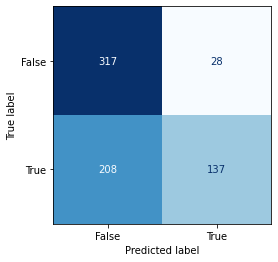

In [59]:
ConfusionMatrixDisplay.from_predictions(y_true=test_y_actual, y_pred=test_y_pred, cmap="Blues", display_labels=["False", "True"], colorbar=False)

### Confusion Matrix with Normalizing

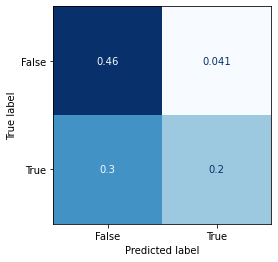

In [70]:
cfm = ConfusionMatrixDisplay.from_predictions(y_true=test_y_actual, y_pred=test_y_pred, cmap="Blues", display_labels=["False", "True"], colorbar=False, normalize="all")

In [66]:
rs = recall_score(test_y_actual, test_y_pred)
ps = precision_score(test_y_actual, test_y_pred)
acc_score = accuracy_score(test_y_actual, test_y_pred)
f1_score = f1_score(test_y_actual, test_y_pred)

In [68]:
print(f"Recall: {round(rs, 2)}\t\t\tPrecision: {round(ps, 2)}\nAccuracy: {round(acc_score, 2)}\t\tF1 Score: {round(f1_score, 2)}")

Recall: 0.4			Precision: 0.83
Accuracy: 0.66		F1 Score: 0.54
